In [1]:
# Import own library
from function.preprocess import *
from function.eval_netrics import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
from timeit import default_timer as timer

In [3]:
def give_column_name_ann(source_path, destination_path):
    
    # Initiate Timer 
    top_timer = timer()
    start_time = timer()
    
    # Creating empty list to store how many data is used
    values = []
    
    # Define csv path
    csv_path = glob.glob(source_path)
    
    for csv_file in csv_path:
        df = pd.read_csv(csv_file)
        
        column_list = ['index','lat', 'lon', 'alt', 'X', 'Y', 'Z',
                       'psi', 'theta', 'phi','TAS', 'JSHead', 'JSPitch', 'JSRoll',
                      'throttle', 'thrust', 'fuel_flow', 'rudder', 'elevator',
                      'left_ail', 'right_ail', 'ground_speed', 'wind_speed', 'roll_rate',
                      'num_wp', 'x_wp', 'y_wp', 'z_wp', 'wp_dist', 'yaw_reff',
                      'wp_stat', 'ph_stat', 'wl_stat', 'yaw_error', 'JSRoll_Sim', 'JSRoll_PID', 'Roll_lim_stat', 'KP', 'KD', 'error_rate']

        df.columns = column_list

        # Save as new CSV files
        file_name = csv_file.split('\\')[-1]
        if os.path.exists(Path(destination_path)):
            df.to_csv(os.path.join(destination_path,file_name), index=False)
        else:
            print('Please Create the Folder First!')
            
        print('Done:', file_name)   
        print('-------------------------------------------------------------------------------------------------------------------------------')
        values.append('1')
        
    print("Time used: {:.2f} minutes".format((timer() - start_time)/60))
    start_time   = timer()
    print("Number of used data:", len(values)) 

In [5]:
def plot_csv(file_path):
    
    import glob
    
    # Initiate Timer 
    top_timer = timer()
    start_time = timer()

    # Initiate file path of csv files
    csv_files = glob.glob(os.path.join(file_path))
    
    # Creating empty list to store how many data is used
    values = []
    count = 0 

    # loop over the list of csv files
    for f in csv_files:
        df = pd.read_csv(f) # Read csv files as dataframe
        x_wp_list, y_wp_list = unique_coor(df)
        combined = zip(x_wp_list, y_wp_list)
        
        # Finding index of first waypoint
        index_x, index_y = index_wp(df)
        
        # Plotting
        figure, axis = plt.subplots(nrows=1, ncols=4,figsize=(15,3))
        figure.subplots_adjust(hspace=0.7)

        # First row plotting
        axis[0].plot(df['X'],df['Y'], label='Aircraft Path')
        axis[0].plot(df['x_wp'],df['y_wp'], label='Waypoint Path')
        axis[0].plot(df['x_wp'], df['y_wp'], 'x', color = 'r')
        axis[0].set_title("Aircraft Path vs Waypoint Path ")
        axis[0].set_xlabel('Horizontal Distance (m)')
        axis[0].set_ylabel('Vertical Distance (m)')
        axis[0].legend(loc='best')
        
        for coor in combined:
            circle = plt.Circle(coor, 450, fill=False)
            axis[0].add_patch(circle)
        
        axis[1].plot(df['phi'][:-(int(0.01*len(df)))])
        axis[1].set_title("Roll Angle")
        axis[1].set_xlabel('Time (s)')
        axis[1].set_ylabel('Magnitude (Degree)')
        
        axis[2].plot(df['JSRoll_Sim'][:-(int(0.01*len(df)))], label='Joystick Roll')
        axis[2].set_title("Joystick Roll")
        axis[2].set_xlabel('Time (s)')
        axis[2].set_ylabel('Ratio')

        axis[3].plot(df['yaw_error'][:-(int(0.01*len(df)))], label='Yaw Error')
        axis[3].set_title("Yaw Error")
        axis[3].set_xlabel('Time (s)')
        axis[3].set_ylabel('Magnitude (Degree)')
        
        
        # Calculate minimum distance to each waypoint, min&max yaw_error
        min_distance = minimum_distance(df)
        min_yaw_error = np.min(df['yaw_error'][index_x[1]:-(int(0.01*len(df)))])
        max_yaw_error = np.max(df['yaw_error'][index_x[1]:-(int(0.01*len(df)))])
        
        if 'PID' in f:
            # Calculate KP value
            KP = np.round(df['KP'][int(0.4*len(df))]/df['yaw_error'][int(0.4*len(df))],5)
            
            # Find index where error rate != 0
            index_stor = []
            for index,value in enumerate(df['KD']):
                if value !=0:
                    index_stor.append(index)
                    break
            # Calculate KD
            KD = np.round(float(df['KD'][index_stor])/float(df['error_rate'][index_stor]),5)
        
            print('Plot below is for: {} (Kp = {}, Kd = {})'.format(f.split("\\")[-1], KP,KD))
            print('Yaw error average is: {:.1f} '.format(np.mean(df['yaw_error'])) + u"\u00B1 " + "{:.2f}".format(np.std(min_distance)))
            print('With minimum value starting from 1st WP is : {:.1f} and maximum value is: {:.1f}'.format(min_yaw_error, max_yaw_error))
            print('Minimum distance to each waypoint as follow: ', np.round(min_distance,1).tolist())
            print('With average of {:.1f} '.format(np.mean(min_distance)) + u"\u00B1 " + "{:.2f}".format(np.std(min_distance)))
            print('Maximum roll angle starting from 1st WP is: ', np.max(np.abs(df['phi'][index_x[1]:-(int(0.01*len(df)))])))
            print('-----------------------------------------------------------------------------------------------------------------------------')
            values.append('1')
            plt.show()
        else:
            print('Plot below is for:', f.split("\\")[-1]) 
            print('Yaw error average is: {:.1f} '.format(np.mean(df['yaw_error'])) + u"\u00B1 " + "{:.2f}".format(np.std(min_distance)))
            print('With minimum value starting from 1st WP is : {:.1f} and maximum value is: {:.1f}'.format(min_yaw_error, max_yaw_error))
            print('Minimum distance to each waypoint as follow: ', np.round(min_distance,1).tolist())
            print('With average of {:.1f} '.format(np.mean(min_distance)) + u"\u00B1 " + "{:.2f}".format(np.std(min_distance)))
            print('Maximum roll angle starting from 1st WP is: ', np.max(np.abs(df['phi'][index_x[1]:-(int(0.01*len(df)))])))
            print('-----------------------------------------------------------------------------------------------------------------------------')
            values.append('1')

            plt.show()
        
    print("Time used: {:.2f} minutes".format((timer() - start_time)/60))
    start_time   = timer()
    print("Number of used data:", len(values)) 

# Give Column Name ANN

In [14]:
source_path = r"...\PID TEST\*csv"
dest_path = r"...\PID TEST"

In [12]:
source_path = r"...\ANN TEST\SET1\*csv"
dest_path = r"...\ANN TEST\SET1"

In [15]:
give_column_name_ann(source_path, dest_path)

Done: Cirrus1.csv
-------------------------------------------------------------------------------------------------------------------------------
Done: Cirrus2.csv
-------------------------------------------------------------------------------------------------------------------------------
Done: Cirrus3.csv
-------------------------------------------------------------------------------------------------------------------------------
Done: Cirrus4.csv
-------------------------------------------------------------------------------------------------------------------------------
Done: Cirrus5.csv
-------------------------------------------------------------------------------------------------------------------------------
Done: Cirrus6.csv
-------------------------------------------------------------------------------------------------------------------------------
Time used: 0.01 minutes
Number of used data: 6


# Plotting

# SET 1

Plot below is for: Cirrus1.csv
Yaw error average is: 3.9 ± 81.09
With minimum value starting from 1st WP is : -75.4 and maximum value is: 63.9
Minimum distance to each waypoint as follow:  [19.9, 9.6, 7.9, 97.9, 281.1, 17.4, 18.6, 59.0, 8.3, 5.8]
With average of 52.5 ± 81.09
Maximum roll angle starting from 1st WP is:  32.097
-----------------------------------------------------------------------------------------------------------------------------


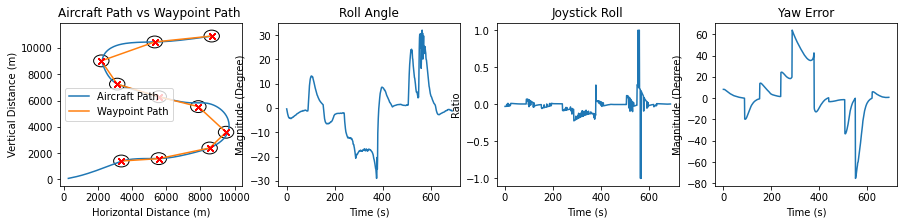

Plot below is for: Cirrus2.csv
Yaw error average is: 4.1 ± 77.91
With minimum value starting from 1st WP is : -74.9 and maximum value is: 64.1
Minimum distance to each waypoint as follow:  [31.1, 13.8, 13.2, 120.6, 278.6, 29.1, 49.5, 51.8, 25.5, 16.6]
With average of 63.0 ± 77.91
Maximum roll angle starting from 1st WP is:  32.578
-----------------------------------------------------------------------------------------------------------------------------


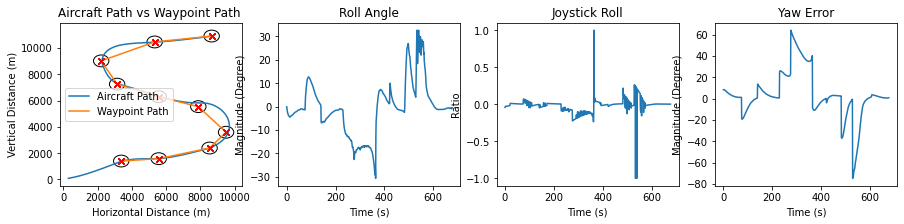

Plot below is for: Cirrus3.csv
Yaw error average is: 16.9 ± 9.38
With minimum value starting from 1st WP is : -0.6 and maximum value is: 80.7
Minimum distance to each waypoint as follow:  [32.3, 32.1, 13.2, 23.7, 9.6]
With average of 22.2 ± 9.38
Maximum roll angle starting from 1st WP is:  17.343
-----------------------------------------------------------------------------------------------------------------------------


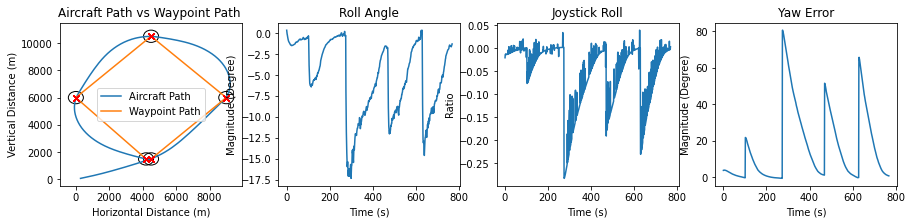

Plot below is for: Cirrus4.csv
Yaw error average is: 16.6 ± 11.27
With minimum value starting from 1st WP is : -1.0 and maximum value is: 80.8
Minimum distance to each waypoint as follow:  [8.3, 35.1, 12.6, 27.8, 6.9]
With average of 18.1 ± 11.27
Maximum roll angle starting from 1st WP is:  17.447
-----------------------------------------------------------------------------------------------------------------------------


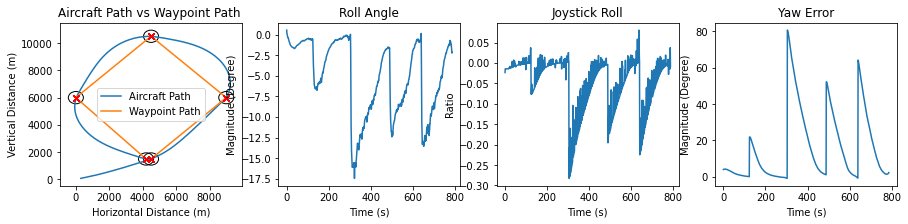

Time used: 0.08 minutes
Number of used data: 4


In [18]:
plot_path = r"...\ANN TEST\SET1\*csv"
plot_csv(plot_path)

# SET 2

Plot below is for: Cirrus1.csv
Yaw error average is: 4.1 ± 9.10
With minimum value starting from 1st WP is : -71.1 and maximum value is: 171.1
Minimum distance to each waypoint as follow:  [23.0, 2.8, 9.6, 9.5, 7.0, 15.1, 32.0, 22.7, 27.4, 20.1]
With average of 16.9 ± 9.10
Maximum roll angle starting from 1st WP is:  42.169
-----------------------------------------------------------------------------------------------------------------------------


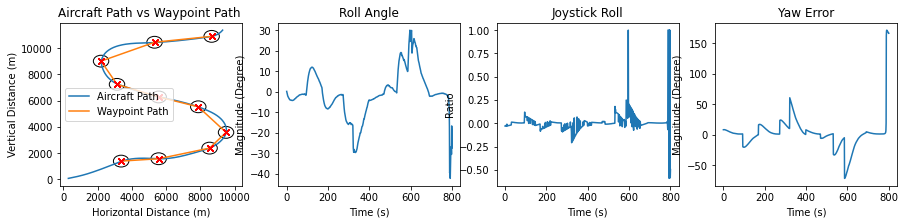

Plot below is for: Cirrus2.csv
Yaw error average is: 1.8 ± 7.96
With minimum value starting from 1st WP is : -69.8 and maximum value is: 62.2
Minimum distance to each waypoint as follow:  [27.2, 4.1, 14.2, 9.5, 16.8, 13.3, 30.8, 8.7, 17.1, 9.1]
With average of 15.1 ± 7.96
Maximum roll angle starting from 1st WP is:  33.043
-----------------------------------------------------------------------------------------------------------------------------


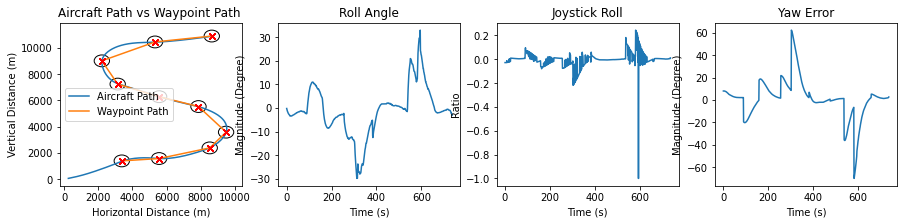

Plot below is for: Cirrus3.csv
Yaw error average is: 11.7 ± 5.15
With minimum value starting from 1st WP is : 1.1 and maximum value is: 81.2
Minimum distance to each waypoint as follow:  [12.6, 17.5, 25.6, 13.9, 23.6]
With average of 18.6 ± 5.15
Maximum roll angle starting from 1st WP is:  29.922
-----------------------------------------------------------------------------------------------------------------------------


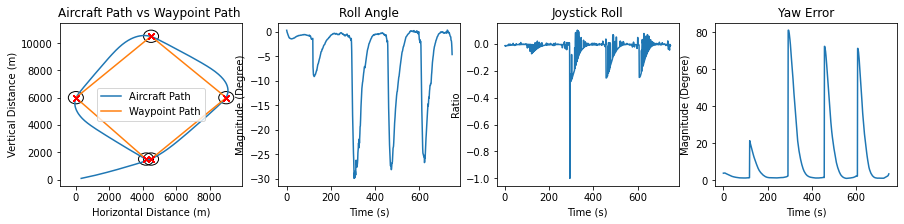

Plot below is for: Cirrus4.csv
Yaw error average is: 10.7 ± 12.53
With minimum value starting from 1st WP is : 0.7 and maximum value is: 80.5
Minimum distance to each waypoint as follow:  [10.3, 38.6, 32.3, 28.4, 6.7]
With average of 23.3 ± 12.53
Maximum roll angle starting from 1st WP is:  30.22
-----------------------------------------------------------------------------------------------------------------------------


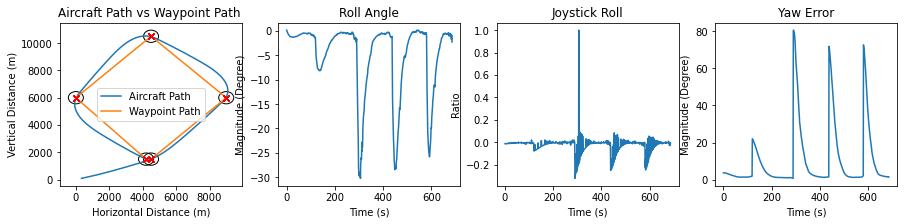

Time used: 0.06 minutes
Number of used data: 4


In [19]:
plot_path = r"...\ANN TEST\SET2\*csv"
plot_csv(plot_path)

# SET 3

Plot below is for: Cirrus1.csv
Yaw error average is: 1.9 ± 17.45
With minimum value starting from 1st WP is : -75.6 and maximum value is: 61.8
Minimum distance to each waypoint as follow:  [44.5, 38.3, 17.6, 20.6, 35.9, 28.6, 62.3, 70.4, 43.6, 15.2]
With average of 37.7 ± 17.45
Maximum roll angle starting from 1st WP is:  36.514
-----------------------------------------------------------------------------------------------------------------------------


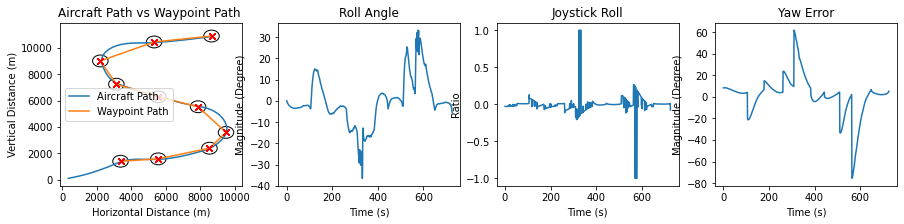

Plot below is for: Cirrus2.csv
Yaw error average is: 1.5 ± 19.76
With minimum value starting from 1st WP is : -74.5 and maximum value is: 61.0
Minimum distance to each waypoint as follow:  [44.7, 34.4, 11.9, 13.3, 15.2, 26.4, 66.7, 62.6, 56.0, 23.4]
With average of 35.5 ± 19.76
Maximum roll angle starting from 1st WP is:  45.567
-----------------------------------------------------------------------------------------------------------------------------


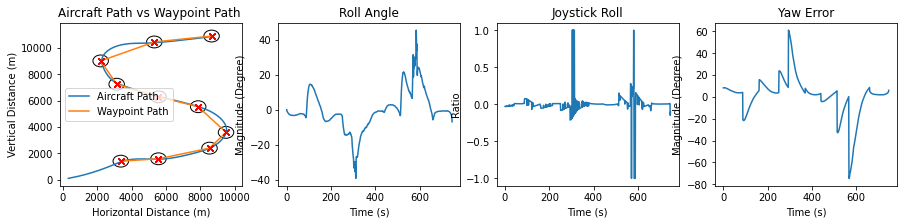

Plot below is for: Cirrus4.csv
Yaw error average is: 13.8 ± 6.48
With minimum value starting from 1st WP is : 2.5 and maximum value is: 78.0
Minimum distance to each waypoint as follow:  [16.8, 23.3, 29.0, 10.7, 14.7]
With average of 18.9 ± 6.48
Maximum roll angle starting from 1st WP is:  23.23
-----------------------------------------------------------------------------------------------------------------------------


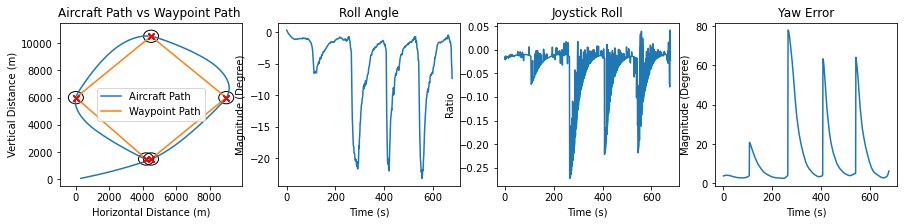

Plot below is for: Cirrus5.csv
Yaw error average is: 13.6 ± 9.28
With minimum value starting from 1st WP is : 2.7 and maximum value is: 77.3
Minimum distance to each waypoint as follow:  [19.8, 5.7, 12.7, 11.5, 32.7]
With average of 16.5 ± 9.28
Maximum roll angle starting from 1st WP is:  29.732
-----------------------------------------------------------------------------------------------------------------------------


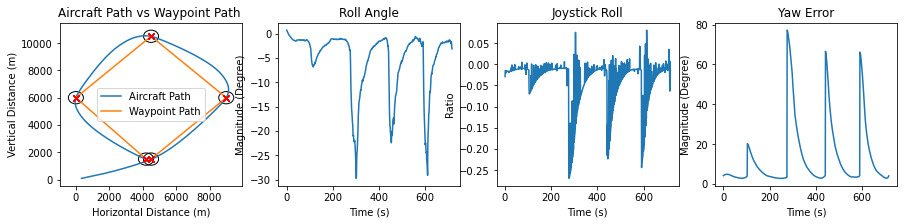

Time used: 0.06 minutes
Number of used data: 4


In [21]:
plot_path = r"...\ANN TEST\SET3\*csv"
plot_csv(plot_path)

# SET 4

Plot below is for: Cirrus1.csv
Yaw error average is: -2.2 ± 15.00
With minimum value starting from 1st WP is : -76.9 and maximum value is: 58.2
Minimum distance to each waypoint as follow:  [4.3, 25.0, 40.1, 42.4, 55.1, 24.2, 14.2, 31.4, 13.9, 13.9]
With average of 26.5 ± 15.00
Maximum roll angle starting from 1st WP is:  31.38300000000001
-----------------------------------------------------------------------------------------------------------------------------


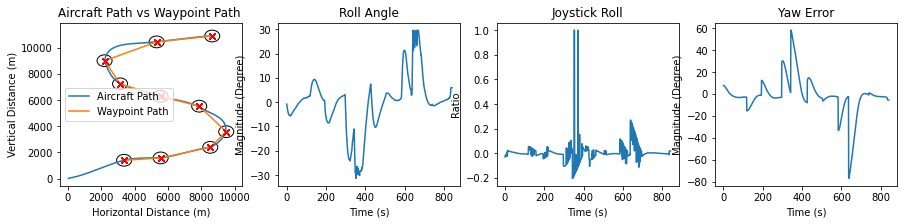

Plot below is for: Cirrus2.csv
Yaw error average is: -2.3 ± 21.23
With minimum value starting from 1st WP is : -75.7 and maximum value is: 58.2
Minimum distance to each waypoint as follow:  [5.3, 29.5, 44.9, 57.2, 80.6, 23.7, 14.6, 42.4, 21.6, 22.7]
With average of 34.2 ± 21.23
Maximum roll angle starting from 1st WP is:  31.363000000000003
-----------------------------------------------------------------------------------------------------------------------------


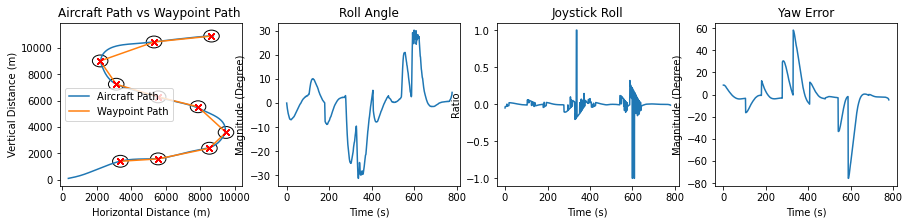

Plot below is for: Cirrus3.csv
Yaw error average is: 7.4 ± 18.65
With minimum value starting from 1st WP is : -3.7 and maximum value is: 87.2
Minimum distance to each waypoint as follow:  [34.2, 55.3, 62.8, 53.6, 11.3]
With average of 43.4 ± 18.65
Maximum roll angle starting from 1st WP is:  35.093
-----------------------------------------------------------------------------------------------------------------------------


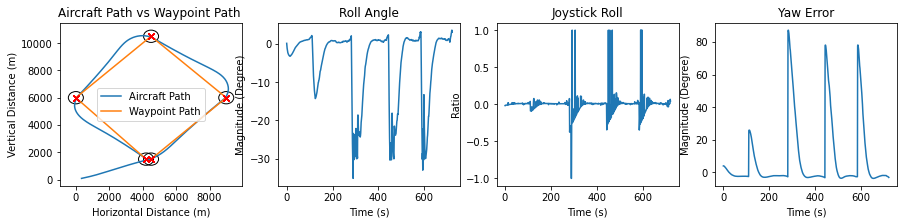

Plot below is for: Cirrus4.csv
Yaw error average is: 6.5 ± 20.38
With minimum value starting from 1st WP is : -4.3 and maximum value is: 87.5
Minimum distance to each waypoint as follow:  [36.3, 59.7, 69.2, 53.5, 11.3]
With average of 46.0 ± 20.38
Maximum roll angle starting from 1st WP is:  56.32
-----------------------------------------------------------------------------------------------------------------------------


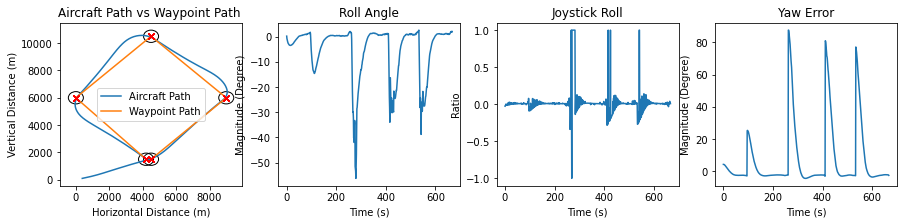

Time used: 0.06 minutes
Number of used data: 4


In [22]:
plot_path = r"...\SET4\*csv"
plot_csv(plot_path)

# PID

Plot below is for: Cirrus1.csv (Kp = -0.0035, Kd = -0.0308)
Yaw error average is: 0.7 ± 18.16
With minimum value starting from 1st WP is : -73.9 and maximum value is: 62.0
Minimum distance to each waypoint as follow:  [61.4, 42.0, 15.8, 11.5, 21.4, 24.5, 67.5, 20.1, 37.3, 24.4]
With average of 32.6 ± 18.16
Maximum roll angle starting from 1st WP is:  32.705999999999996
-----------------------------------------------------------------------------------------------------------------------------


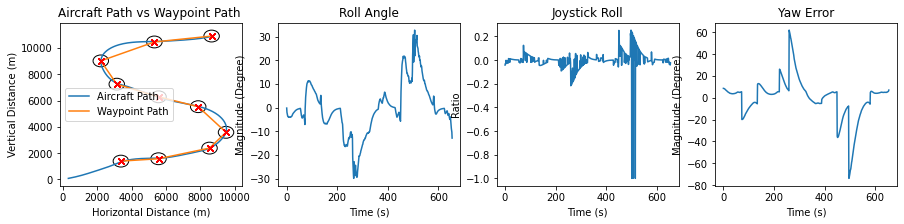

Plot below is for: Cirrus4.csv (Kp = -0.0035, Kd = -0.0308)
Yaw error average is: 0.8 ± 8.84
With minimum value starting from 1st WP is : -73.0 and maximum value is: 63.2
Minimum distance to each waypoint as follow:  [16.7, 26.8, 21.1, 12.9, 36.5, 16.7, 23.2, 28.6, 23.9, 2.7]
With average of 20.9 ± 8.84
Maximum roll angle starting from 1st WP is:  30.752
-----------------------------------------------------------------------------------------------------------------------------


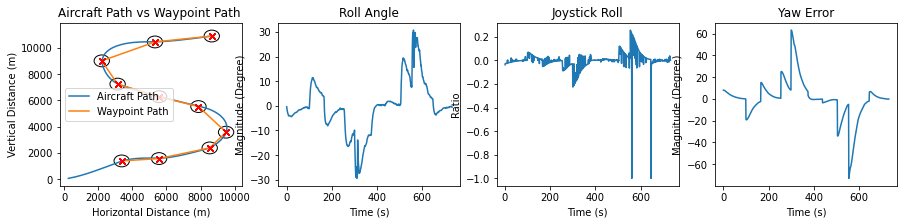

Plot below is for: Cirrus5.csv (Kp = -0.0035, Kd = -0.0308)
Yaw error average is: 9.4 ± 18.27
With minimum value starting from 1st WP is : -0.5 and maximum value is: 82.3
Minimum distance to each waypoint as follow:  [20.7, 57.7, 48.9, 49.4, 10.9]
With average of 37.5 ± 18.27
Maximum roll angle starting from 1st WP is:  32.515
-----------------------------------------------------------------------------------------------------------------------------


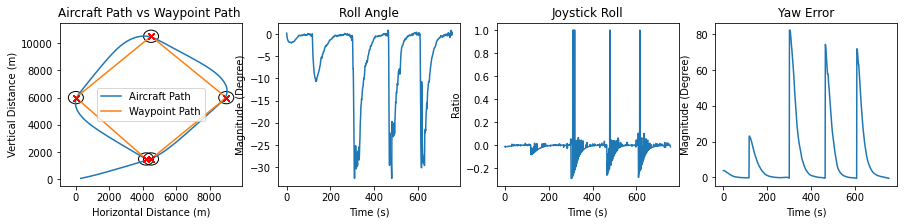

Plot below is for: Cirrus6.csv (Kp = -0.0035, Kd = -0.0308)
Yaw error average is: 10.3 ± 13.42
With minimum value starting from 1st WP is : -0.8 and maximum value is: 82.5
Minimum distance to each waypoint as follow:  [20.1, 51.0, 36.4, 38.1, 13.6]
With average of 31.8 ± 13.42
Maximum roll angle starting from 1st WP is:  37.799
-----------------------------------------------------------------------------------------------------------------------------


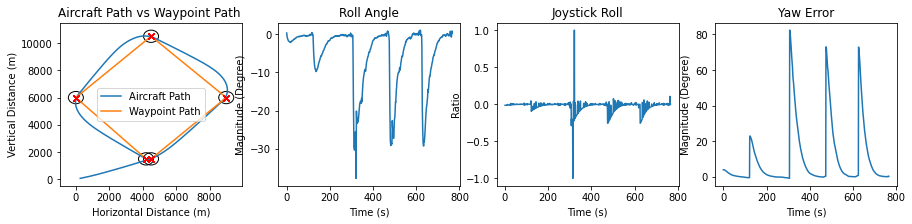

Time used: 0.06 minutes
Number of used data: 4


In [25]:
plot_path = r"...\PID TEST\*csv"
plot_csv(plot_path)